In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import classification_report, confusion_matrix

from pathlib import Path

In [3]:
from pathlib import Path
import os

# Caminhos
data_dir = Path('chest_xray')
conjuntos = ['train', 'val', 'test']
categorias = ['NORMAL', 'PNEUMONIA']

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Dicionário para armazenar resultados
contagens = {}

# Contar imagens em cada pasta
for conjunto in conjuntos:
    for categoria in categorias:
        pasta = data_dir / conjunto / categoria
        qtd = len(list(pasta.glob('*.jpeg')))
        contagens[f"{conjunto}_{categoria.lower()}"] = qtd

# Exibição formatada
for conjunto in conjuntos:
    print(f"\n📁 {conjunto.upper()}:")
    for categoria in categorias:
        chave = f"{conjunto}_{categoria.lower()}"
        print(f"{categoria}: {contagens[chave]} imagens")

# Totais por categoria (somando train + val + test)
normal_imgs_count = sum(contagens[k] for k in contagens if "normal" in k)
pneumonia_imgs_count = sum(contagens[k] for k in contagens if "pneumonia" in k)

print(f"\n🩺 Imagens diretório NORMAL: {normal_imgs_count}, "
      f"Imagens no diretório PNEUMONIA: {pneumonia_imgs_count}")

# Total geral
total = normal_imgs_count + pneumonia_imgs_count
print(f"➡️ Total geral de imagens: {total}")

# Configurações do dataset
image_size = (224, 224)
batch_size = 32


📁 TRAIN:
NORMAL: 1341 imagens
PNEUMONIA: 3875 imagens

📁 VAL:
NORMAL: 8 imagens
PNEUMONIA: 8 imagens

📁 TEST:
NORMAL: 234 imagens
PNEUMONIA: 390 imagens

🩺 Imagens diretório NORMAL: 1583, Imagens no diretório PNEUMONIA: 4273
➡️ Total geral de imagens: 5856


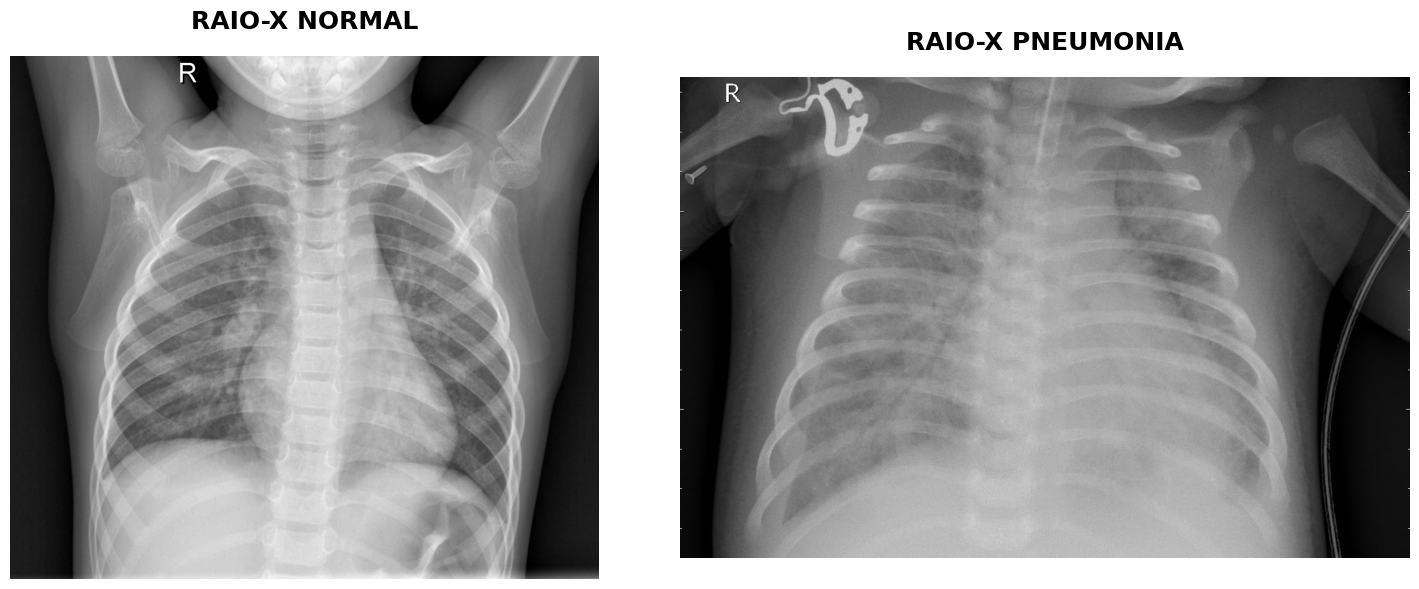

In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import os

# Caminhos
data_dir = Path('chest_xray')
train_dir = data_dir / 'train'

# Encontrar primeira imagem de NORMAL
normal_dir = train_dir / 'NORMAL'
normal_imgs = list(normal_dir.glob('*.jpeg')) + list(normal_dir.glob('*.jpg')) + list(normal_dir.glob('*.png'))
normal_imgs.sort()
primeira_normal = normal_imgs[0] if normal_imgs else None

# Encontrar primeira imagem de PNEUMONIA
pneumonia_dir = train_dir / 'PNEUMONIA'
pneumonia_imgs = list(pneumonia_dir.glob('*.jpeg')) + list(pneumonia_dir.glob('*.jpg')) + list(pneumonia_dir.glob('*.png'))
pneumonia_imgs.sort()
primeira_pneumonia = pneumonia_imgs[0] if pneumonia_imgs else None

# Exibir as imagens
if primeira_normal and primeira_pneumonia:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Configurar fundo branco
    fig.patch.set_facecolor('white')
    
    # Imagem NORMAL
    img_normal = Image.open(primeira_normal)
    ax1.imshow(img_normal, cmap='gray')
    ax1.set_title('RAIO-X NORMAL', fontsize=18, fontweight='bold', pad=20)
    ax1.axis('off')
    
    # Imagem PNEUMONIA
    img_pneumonia = Image.open(primeira_pneumonia)
    ax2.imshow(img_pneumonia, cmap='gray')
    ax2.set_title('RAIO-X PNEUMONIA', fontsize=18, fontweight='bold', pad=20)
    ax2.axis('off')
    
    plt.tight_layout()
    
    plt.show()
else:
    print("Não foi possível encontrar as imagens necessárias")

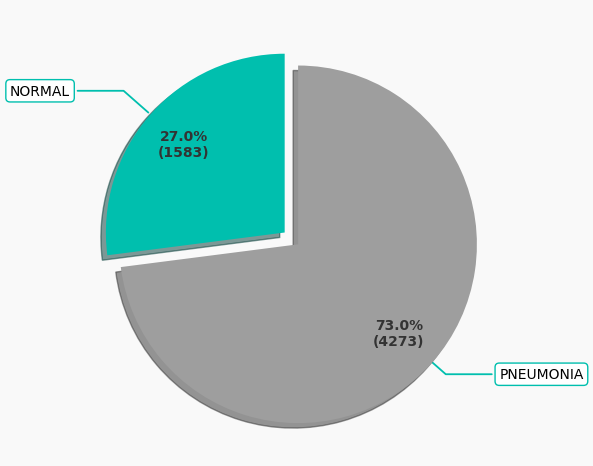

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# --- Dados ---
labels = ["NORMAL", "PNEUMONIA"]
sizes = [normal_imgs_count, pneumonia_imgs_count]
explode = (0, 0.1)

# --- Função para mostrar porcentagem + valor absoluto ---
def func(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{pct:.1f}%\n({absolute})"

# --- Estilo claro e limpo ---
plt.style.use("default")

fig, ax = plt.subplots(figsize=(6, 6), facecolor="#f9f9f9")  # fundo suave
wedges, texts, autotexts = ax.pie(
    sizes,
    explode=explode,
    labels=None,  # rótulos fora da pizza
    autopct=lambda pct: func(pct, sizes),
    pctdistance=0.75,
    startangle=90,
    colors=['#00bfae', "#9e9e9e"],  # verde água e cinza neutro
    shadow=True
)

# --- Rótulos fora da pizza ---
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="#00bfae", lw=1)
kw = dict(arrowprops=dict(arrowstyle="-", color="#00bfae", lw=1.3),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i],
                xy=(x, y), xytext=(1.2*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, **kw)

# --- Texto interno (percentual + valores) ---
plt.setp(autotexts, size=10, weight="bold", color="#333333")

# --- Ajustes finais ---
ax.set_aspect('equal')  # mantém formato circular
plt.tight_layout()
plt.show()


In [6]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print('Class indices:', train_generator.class_indices)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


## Construção do modelo com MobileNetV2

Usamos `include_top=False` e `weights='imagenet'`. A base é inicialmente congelada; adicionamos `GlobalAveragePooling2D`, `Dropout` e uma camada densa com sigmoid para saída binária.


In [7]:
if tf.test.gpu_device_name():
    print('GPU encontrada: {}'.format(tf.test.gpu_device_name()))
else:
    print("Nenhuma GPU encontrada. Verifique as configurações do ambiente de execução.")

Nenhuma GPU encontrada. Verifique as configurações do ambiente de execução.


In [8]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False  # fase 1: congelado

inputs = layers.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,713 (9.26 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

In [9]:
# Imports necessários para o balanceamento
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras import callbacks

# Callbacks
checkpoint_path = 'mobilenetv2_best_phase1.h5'
es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
mc = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

# 🔹 Cálculo automático dos pesos das classes (NORMAL x PNEUMONIA)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Pesos das classes:", class_weights)

# Training - Phase 1 (base frozen)
train_steps = train_generator.samples // batch_size
val_steps = validation_generator.samples // batch_size

history1 = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_steps),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=max(1, val_steps),
    callbacks=[es, rl, mc],
    class_weight=class_weights  # 🔸 PESOS ADICIONADOS AQUI
)

model.save('mobilenetv2_FASE1.h5')


Pesos das classes: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


c:\Users\Pizolato\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6734 - auc: 0.7932 - loss: 0.6317

163/163 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.7391 - auc: 0.8918 - loss: 0.4742 - val_accuracy: 0.8125 - val_auc: 0.9844 - val_loss: 0.3792 - learning_rate: 1.0000e-04
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.8257 - auc: 0.9592 - loss: 0.3186 - val_accuracy: 0.7500 - val_auc: 0.9688 - val_loss: 0.3817 - learning_rate: 1.0000e-04
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8487 - auc: 0.9676 - loss: 0.2842

163/163 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.8608 - auc: 0.9678 - loss: 0.2724 - val_accuracy: 0.8125 - val_auc: 0.9531 - val_loss: 0.3733 - learning_rate: 1.0000e-04
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8704 - auc: 0.9700 - loss: 0.2558

163/163 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.8758 - auc: 0.9724 - loss: 0.2477 - val_accuracy: 0.8750 - val_auc: 0.9531 - val_loss: 0.3261 - learning_rate: 1.0000e-04
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8935 - auc: 0.9750 - loss: 0.2263

163/163 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.8913 - auc: 0.9751 - loss: 0.2278 - val_accuracy: 0.8750 - val_auc: 0.9531 - val_loss: 0.3000 - learning_rate: 1.0000e-04
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8996 - auc: 0.9754 - loss: 0.2190

163/163 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.8993 - auc: 0.9753 - loss: 0.2183 - val_accuracy: 0.9375 - val_auc: 0.9531 - val_loss: 0.2828 - learning_rate: 1.0000e-04
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9089 - auc: 0.9770 - loss: 0.2066

163/163 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9122 - auc: 0.9798 - loss: 0.1947 - val_accuracy: 0.8750 - val_auc: 0.9531 - val_loss: 0.2784 - learning_rate: 1.0000e-04
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9173 - auc: 0.9782 - loss: 0.1983

163/163 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9237 - auc: 0.9808 - loss: 0.1838 - val_accuracy: 0.8750 - val_auc: 0.9531 - val_loss: 0.2674 - learning_rate: 1.0000e-04
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9195 - auc: 0.9816 - loss: 0.1844

163/163 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9224 - auc: 0.9827 - loss: 0.1770 - val_accuracy: 0.8750 - val_auc: 0.9531 - val_loss: 0.2626 - learning_rate: 1.0000e-04
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9220 - auc: 0.9825 - loss: 0.1759

163/163 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.9214 - auc: 0.9815 - loss: 0.1796 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.2173 - learning_rate: 1.0000e-04
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.9271 - auc: 0.9821 - loss: 0.1762 - val_accuracy: 0.9375 - val_auc: 0.9688 - val_loss: 0.2408 - learning_rate: 1.0000e-04
Epoch 12/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9298 - auc: 0.9831 - loss: 0.1670 - val_accuracy: 0.8750 - val_auc: 0.9531 - val_loss: 0.2513 - learning_rate: 1.0000e-04
Epoch 13/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9362 - auc: 0.9861 - loss: 0.1529 - val_accuracy: 0.8750 - val_auc: 0.9688 - val_loss: 0.2340 - learning_rate: 1.0000e-04
Epoch 14/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.9335 - auc: 0.9830 - loss: 0.1678 - val_accuracy: 0.9375 - val_auc: 0.9688 - val_loss: 0.2209 - learning_rate: 5.0000e-05
Epoch 15/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - a

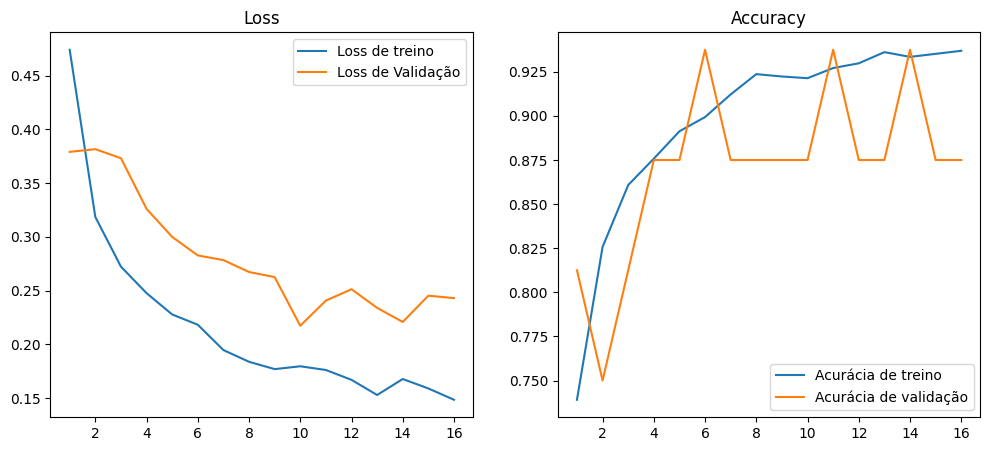

In [19]:
# Função para plotar histórico combinado

def plot_combined(h1, h2=None):
    # combine histories
    hist = {}
    for k, v in h1.history.items():
        hist[k] = v.copy()
    if h2:
        for k, v in h2.history.items():
            hist[k].extend(v)

    epochs = range(1, len(hist['loss'])+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['loss'], label='Loss de treino')
    plt.plot(epochs, hist['val_loss'], label='Loss de Validação')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hist['accuracy'], label='Acurácia de treino')
    plt.plot(epochs, hist['val_accuracy'], label='Acurácia de validação')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

plot_combined(history1)


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 776ms/step - accuracy: 0.9038 - auc: 0.9602 - loss: 0.2571
Test loss: 0.2571 - Test acc: 0.9038 - Test AUC: 0.9602
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 819ms/step
Confusion matrix:
 [[203  31]
 [ 29 361]]

Classification report:

              precision    recall  f1-score   support

      NORMAL       0.88      0.87      0.87       234
   PNEUMONIA       0.92      0.93      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.90      0.90      0.90       624



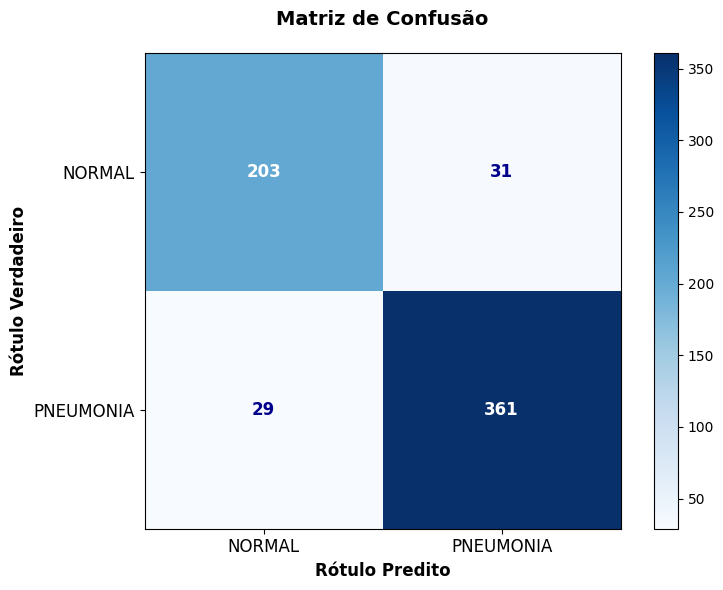

In [16]:
# Avaliação no conjunto de teste usando o melhor modelo da fase 2 (se existir) ou fase 1
import os
best_path = 'mobilenetv2_best_FASE2.h5' if os.path.exists('mobilenetv2_best_FASE2.h5') else 'mobilenetv2_FASE1.h5'
from tensorflow.keras.models import load_model
best = load_model(best_path)

test_steps = test_generator.samples // batch_size + 1
loss, acc, auc = best.evaluate(test_generator, steps=test_steps)
print(f'Test loss: {loss:.4f} - Test acc: {acc:.4f} - Test AUC: {auc:.4f}')

# Predictions
y_pred_prob = best.predict(test_generator, steps=test_steps)
y_pred = (y_pred_prob.ravel() >= 0.5).astype(int)
y_true = test_generator.classes[:len(y_pred)]

cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:\n', cm)
print('\nClassification report:\n')
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de Confusão'):
    plt.figure(figsize=(8, 6))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    # CORES PROFISSIONAIS - azul escuro
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    # CONFIGURAÇÃO DOS TEXTOS
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=12,
                 fontweight='bold',
                 color='white' if cm[i, j] > thresh else 'darkblue')
    
    plt.ylabel('Rótulo Verdadeiro', fontsize=12, fontweight='bold')
    plt.xlabel('Rótulo Predito', fontsize=12, fontweight='bold')
    plt.tight_layout()
    
    # MELHORAR ASPECTO GERAL
    plt.grid(False)
    plt.show()

# CHAMADA DA FUNÇÃO
plot_confusion_matrix(cm, classes=list(test_generator.class_indices.keys()), normalize=False)

In [ ]:
# CURVA ROC/AUC - VERSÃO PROFISSIONAL
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_proba, title='Curva ROC - Detecção de Pneumonia'):
    plt.figure(figsize=(8, 6))
    
    # Calcula ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot da curva
    plt.plot(fpr, tpr, color='#2E86AB', linewidth=3, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='#A9A9A9', linestyle='--', linewidth=2, 
             label='Classificador Aleatório (AUC = 0.5)')
    
    # Configurações visuais
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos', fontsize=12, fontweight='bold')
    plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Grade sutil para melhor leitura
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Legenda
    plt.legend(loc='lower right', fontsize=11, frameon=True, fancybox=True)
    
    # Destaque a área sob a curva
    plt.fill_between(fpr, tpr, alpha=0.1, color='#2E86AB')
    
    # Anotação do AUC
    plt.text(0.6, 0.3, f'AUC = {roc_auc:.4f}', 
             fontsize=13, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

    print(f"📊 AUC Score: {roc_auc:.4f}")
    return roc_auc


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 713ms/step


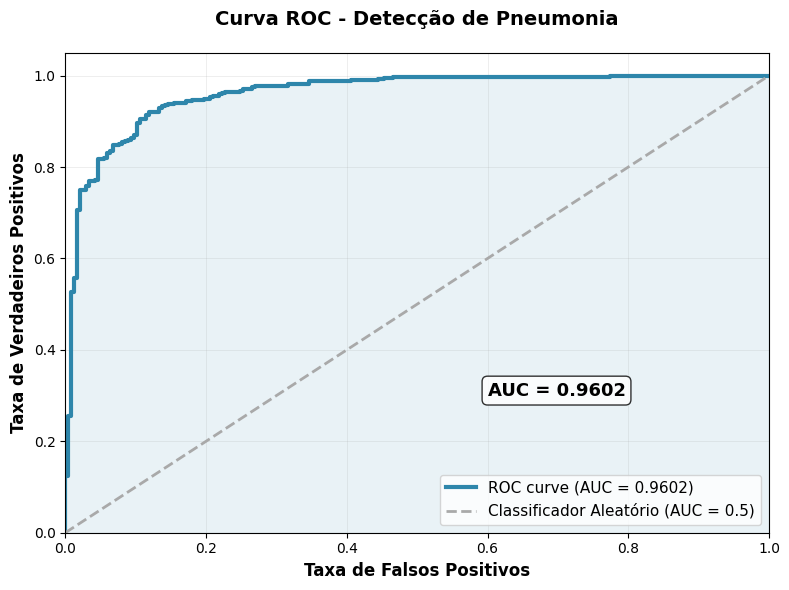

📊 AUC Score: 0.9602
📊 Total de amostras: 624
🔢 Distribuição dos labels: (array([0, 1], dtype=int32), array([234, 390]))
📈 Probabilidades - Min: 0.0000, Max: 0.9999
🎯 AUC esperado: ~0.9602


In [23]:
# 🚀 CURVA ROC COM SEUS DADOS REAIS
y_true = test_generator.classes
y_pred_proba = model.predict(test_generator).ravel()

# Plot da curva ROC profissional
plot_roc_curve(y_true, y_pred_proba)

# 👇 MOSTRANDO ALGUNS DETALhes DOS SEUS DADOS
print(f"📊 Total de amostras: {len(y_true)}")
print(f"🔢 Distribuição dos labels: {np.unique(y_true, return_counts=True)}")
print(f"📈 Probabilidades - Min: {y_pred_proba.min():.4f}, Max: {y_pred_proba.max():.4f}")
print(f"🎯 AUC esperado: ~0.9602")

In [14]:
# ======================================
# CÉLULA – CARREGAR MODELO FINAL
# ======================================
from keras.models import load_model

# Carregar o melhor modelo da fase 2 (fine-tuning)
model = load_model('mobilenetv2_FASE1.h5')

print("✅ Modelo 'mobilenetv2_FASE1.H5' carregado com sucesso!")


✅ Modelo 'mobilenetv2_FASE1.H5' carregado com sucesso!


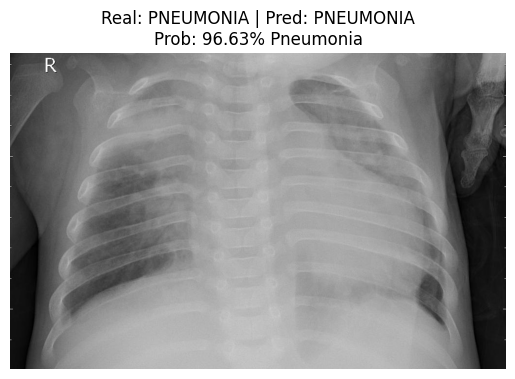

📸 Arquivo: person144_bacteria_690.jpeg
➡️ Classe real: PNEUMONIA
🔮 Predição: PNEUMONIA (96.63% de probabilidade de Pneumonia)



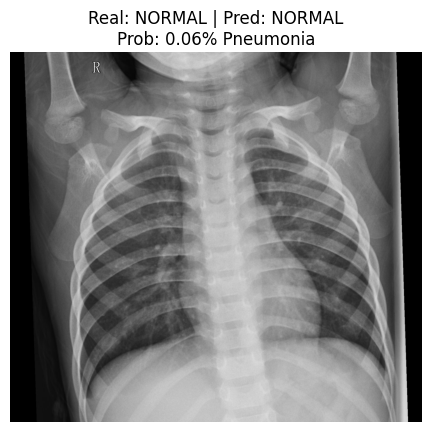

📸 Arquivo: NORMAL2-IM-0130-0001.jpeg
➡️ Classe real: NORMAL
🔮 Predição: NORMAL (0.06% de probabilidade de Pneumonia)



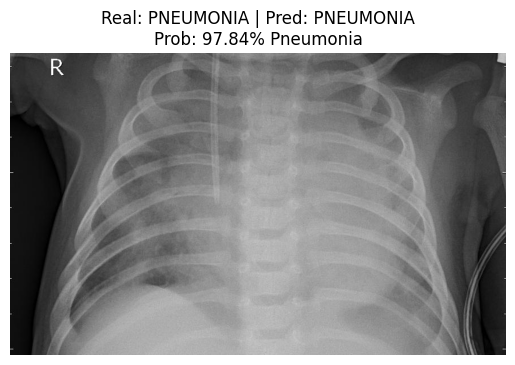

📸 Arquivo: person100_bacteria_480.jpeg
➡️ Classe real: PNEUMONIA
🔮 Predição: PNEUMONIA (97.84% de probabilidade de Pneumonia)



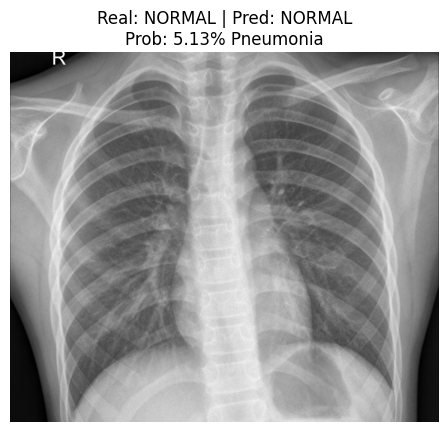

📸 Arquivo: IM-0046-0001.jpeg
➡️ Classe real: NORMAL
🔮 Predição: NORMAL (5.13% de probabilidade de Pneumonia)



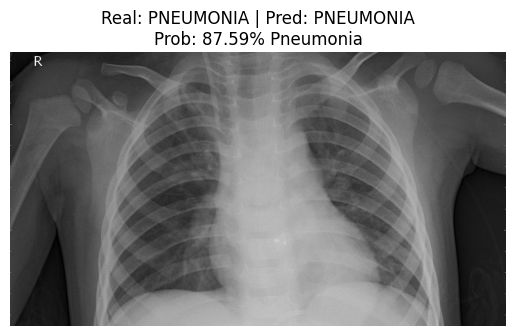

📸 Arquivo: person153_bacteria_725.jpeg
➡️ Classe real: PNEUMONIA
🔮 Predição: PNEUMONIA (87.59% de probabilidade de Pneumonia)



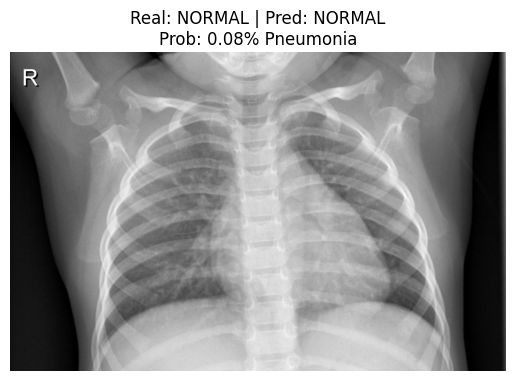

📸 Arquivo: IM-0105-0001.jpeg
➡️ Classe real: NORMAL
🔮 Predição: NORMAL (0.08% de probabilidade de Pneumonia)



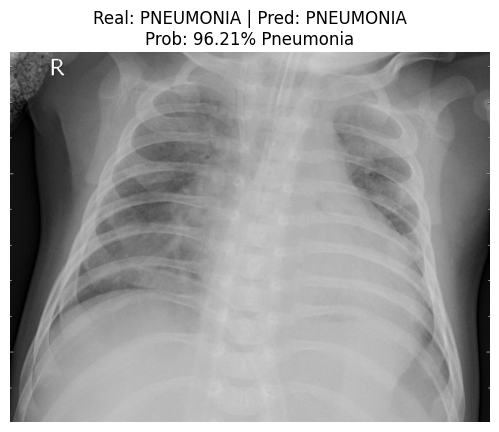

📸 Arquivo: person136_bacteria_649.jpeg
➡️ Classe real: PNEUMONIA
🔮 Predição: PNEUMONIA (96.21% de probabilidade de Pneumonia)



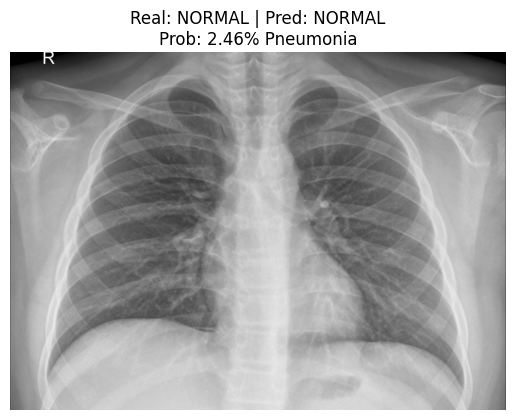

📸 Arquivo: IM-0021-0001.jpeg
➡️ Classe real: NORMAL
🔮 Predição: NORMAL (2.46% de probabilidade de Pneumonia)



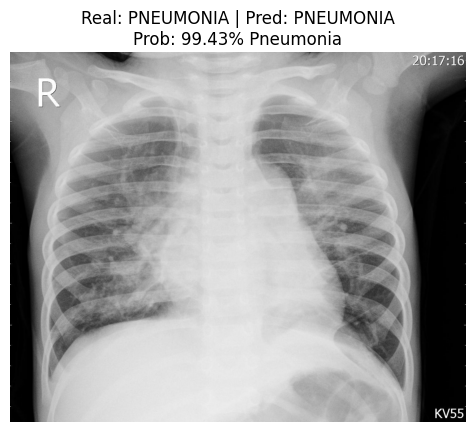

📸 Arquivo: person38_virus_83.jpeg
➡️ Classe real: PNEUMONIA
🔮 Predição: PNEUMONIA (99.43% de probabilidade de Pneumonia)



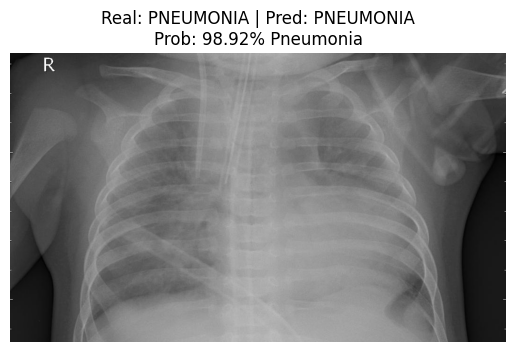

📸 Arquivo: person135_bacteria_646.jpeg
➡️ Classe real: PNEUMONIA
🔮 Predição: PNEUMONIA (98.92% de probabilidade de Pneumonia)



In [15]:
# ======================================
# CÉLULA – TESTE COM 10 IMAGENS AUTOMÁTICAS
# ======================================
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image

# Caminho da pasta de teste
test_dir = r'chest_xray/test'

# Pega todas as imagens das duas classes
normal_imgs = [os.path.join(test_dir, 'NORMAL', f) for f in os.listdir(os.path.join(test_dir, 'NORMAL')) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
pneumonia_imgs = [os.path.join(test_dir, 'PNEUMONIA', f) for f in os.listdir(os.path.join(test_dir, 'PNEUMONIA')) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Junta e escolhe 10 aleatórias
todas_imgs = normal_imgs + pneumonia_imgs
amostras = random.sample(todas_imgs, 10)

# Avaliar cada imagem
for caminho_imagem in amostras:
    # Carregar e preparar a imagem
    img = Image.open(caminho_imagem).convert('RGB')
    img_resized = img.resize((224, 224))
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Fazer a previsão
    predicao = model.predict(img_array, verbose=0)
    prob = float(predicao[0][0])
    classe_pred = 'PNEUMONIA' if prob > 0.7 else 'NORMAL'

    # Determinar classe verdadeira com base no caminho
    classe_real = 'PNEUMONIA' if 'PNEUMONIA' in caminho_imagem else 'NORMAL'

    # Mostrar resultado
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Real: {classe_real} | Pred: {classe_pred}\nProb: {prob*100:.2f}% Pneumonia")
    plt.show()

    print(f"📸 Arquivo: {os.path.basename(caminho_imagem)}")
    print(f"➡️ Classe real: {classe_real}")
    print(f"🔮 Predição: {classe_pred} ({prob*100:.2f}% de probabilidade de Pneumonia)\n")
